## Regularised Regression. Principle components Regression. Partial Least Squares Regression.

In [84]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import statsmodels.api as sm
import seaborn as sns
import pickle
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, RidgeCV, ElasticNet

from sklearn.utils import resample


# Set up plotting options for seaborn and matplotlib
sns.set_context('notebook') 
sns.set_style('ticks') 
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [57]:
# load from previous lessons
ames_train_y= pickle.load(open('models/ames_train_y.pickle', 'rb'))
ames_test_y =pickle.load(open('models/ames_test_y.pickle', 'rb'))
ames_train_X=pickle.load(open('models/ames_train_X.pickle', 'rb'))
ames_test_X= pickle.load(open('models/ames_test_X.pickle', 'rb'))
predictors = pickle.load(open('models/predictors.pickle', 'rb'))

ames_ols_all = pickle.load(open('models/ames_ols_all.pickle', 'rb'))

## Hyperparameter tuning: selecting the optimal value of lambda

Recall that both ridge and lasso regression have an additional parameter, lambda, which captures the penalty for incorporating additional features in the model. 


Hence, we need to first find the optimal value of lambda (using cross-validation), and THEN fit the model, and assess its fit.

Also, for both ridge and lasso regression, the SCALE of the variables matters (because the penalty term in the objective function treats all coefficients as comparable!). So we have to use the `StandardScaler()` function to standardize all numeric variables.

We will do all of this in a scikit-learn pipeline:

In [79]:
from sklearn.pipeline import Pipeline

# logspace -  returns numbers spaced evenly on a log scale, base 2, from 2^-15 to 2^15
# total of 50 of them

alphas = list(np.logspace(-15, 15, 50, base=2))

ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('estimator', RidgeCV(alphas=alphas, cv=10)),
])

ridge.fit(ames_train_X, ames_train_y)
best_alpha_ridge = ridge.named_steps.estimator.alpha_
print(best_alpha_ridge)



/Users/darya/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/darya/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


307.68410860151147


In [80]:
# which element was it?
alphas.index(best_alpha_ridge)

38

## Same thing for Lasso regression

In [81]:
from sklearn.pipeline import Pipeline

lasso = Pipeline([
    ('scaler', StandardScaler()),
    ('estimator', LassoCV(alphas=alphas, cv=10)),
])

lasso.fit(ames_train_X, ames_train_y)
best_alpha_lasso = lasso.named_steps.estimator.alpha_
print(best_alpha_lasso)


/Users/darya/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/darya/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/darya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.0005952215108420286


In [78]:
alphas.index(best_alpha_lasso)

24

## Combine the two

In [85]:
parametersGrid = {"alpha": alphas,
                "l1_ratio": np.arange(0.0, 1.0, 0.1)}

enet = Pipeline([
    ('scaler', StandardScaler()),
    ('estimator', GridSearchCV(ElasticNet(), parametersGrid, scoring='r2', cv=10)),
])

enet.fit(ames_train_X, ames_train_y)
#best_alpha_lasso = lasso.named_steps.estimator.alpha_
#print(best_alpha_lasso)

/Users/darya/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/darya/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/darya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/darya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may c

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('estimator', GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False...   pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0))])

In [87]:
best_alpha_enet = enet.named_steps.estimator


In [88]:
print(best_alpha_enet)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [3.0517578125e-05, 4.6650268103188835e-05, 7.131127854200916e-05, 0.00010900898653031315, 0.00016663505952099585, 0.0002547243483806199, 0.0003893808052425849, 0.0005952215108420286, 0.0009098770206413878, 0.0013908707558638051, 0.0021261350881830966, 0.0032500866052043082, 0.00... 21436.10402812763, 32768.0], 'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)


In [58]:
def plot_coefficients(model, labels):
    coef = model.coef_

    table = pd.Series(coef.ravel(), index = labels).sort_values(ascending=True, inplace=False)
    
    reference = pd.Series(np.abs(coef.ravel()), index = labels).sort_values(ascending=False, inplace=False)
    reference = reference.iloc[:20]
    table = table[reference.index]
    table = table.sort_values(ascending=True, inplace=False)

    fig, ax = fig, ax = plt.subplots()
    table.T.plot(kind='barh', edgecolor='black', width=0.7, linewidth=.8, alpha=0.9, ax=ax)
    ax.tick_params(axis=u'y', length=0) 
    ax.set_title('Estimated coefficients (twenty largest in absolute value)', fontsize=14)
    sns.despine()
    return fig, ax

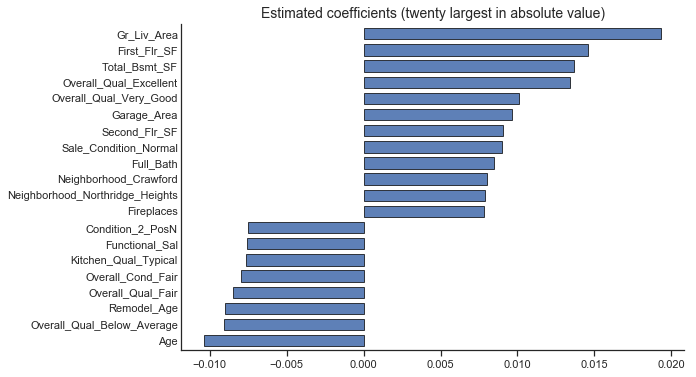

In [63]:
plot_coefficients(ridge._final_estimator, predictors)# the final_estimator attribute refers to the pipeline
plt.show()